In [1]:
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent   # notebooks -> racine
os.chdir(PROJECT_ROOT)                  # << clé : change le dossier courant
sys.path.insert(0, str(PROJECT_ROOT))

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)


CWD: C:\customer_segmentation
PROJECT_ROOT: C:\customer_segmentation


In [2]:
#Imports des librairies nécessaires  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from src.data.process_features import run_feature_processing

In [3]:
#Import des fonctions utilitaires 

from src.config.load_config import load_config

#chargement de la configuration

config = load_config(str(PROJECT_ROOT / "config" / "config.yaml"))
df_selected, X, feature_names, data_keep = run_feature_processing(config)

print("df_selected shape:", df_selected.shape)

✅ Data Process terminé
➡️ Fichier final : C:\customer_segmentation\data\processed\features_scaled.csv
➡️ Pipeline sauvegardé : C:\customer_segmentation\data\processed\preprocessor.joblib
➡️ data_keep utilisé : ['Income', 'total_spending', 'since_customer', 'Age', 'total_children', 'Recency', 'NumStorePurchases', 'NumWebPurchases', 'AcceptedAny']
df_selected shape: (2240, 9)


In [12]:
X

array([[ 2.35695837e-01,  1.67941681e+00,  2.60298582e+00, ...,
        -5.50784790e-01,  1.40930394e+00,  1.63650876e+00],
       [-2.35454185e-01, -9.61275447e-01, -2.30818692e+00, ...,
        -1.16612540e+00, -1.11040937e+00, -6.11056919e-01],
       [ 7.73998919e-01,  2.82673294e-01, -6.32348736e-04, ...,
         1.29523705e+00,  1.40930394e+00, -6.11056919e-01],
       ...,
       [ 1.89475676e-01,  1.05495122e+00, -6.32348736e-04, ...,
         2.21824797e+00, -7.50450329e-01,  1.63650876e+00],
       [ 6.79401390e-01,  3.93947747e-01, -6.32348736e-04, ...,
         1.29523705e+00,  6.89385848e-01, -6.11056919e-01],
       [ 2.52083460e-02, -7.20457600e-01, -6.32348736e-04, ...,
        -5.50784790e-01, -3.90491285e-01,  1.63650876e+00]],
      shape=(2240, 9))

In [ ]:
# Chargement du modèle KMeans
from joblib import dump, load

models_dir = Path(config["paths"]["models"])
model_path = models_dir / "kmeans_k5.joblib"

if model_path.exists():
    kmeans = load(model_path)
    print(" Modèle chargé:", model_path)
else:
    print(" Modèle non trouvé, on réentraîne KMeans avec K=5")
    kmeans = KMeans(n_clusters=5, random_state=config["seed"], n_init="auto")
    kmeans.fit(X)

✅ Modèle chargé: models\kmeans_k5.joblib


In [ ]:
# Attribution des clusters
labels = kmeans.predict(X)

df_clustered = df_selected.copy()
df_clustered["cluster"] = labels

print(" Clusters assignés")
df_clustered.head()

✅ Clusters assignés


,Income,total_spending,since_customer,Age,total_children,Recency,NumStorePurchases,NumWebPurchases,AcceptedAny,cluster
0,58138.0,1617,5027.0,69,0,58,4,8,1,2
1,46344.0,27,4181.0,72,2,38,2,1,0,4
2,71613.0,776,4578.5,61,0,26,10,8,0,1
3,26646.0,53,4121.0,42,1,26,4,2,0,0
4,58293.0,422,4578.5,45,1,94,6,5,0,1


In [ ]:
# Répartition en pourcentages clients par cluster
cluster_sizes = df_clustered["cluster"].value_counts().sort_index()
cluster_percent = (cluster_sizes / cluster_sizes.sum() * 100).round(2)

cluster_distribution = pd.DataFrame({
    "nb_clients": cluster_sizes,
    "pourcentage_%": cluster_percent
})

cluster_distribution


,nb_clients,pourcentage_%
cluster,,
0,632,28.21
1,471,21.03
2,442,19.73
3,225,10.04
4,470,20.98


In [ ]:
# Profil moyen des clusters
cluster_profiles_mean = df_clustered.groupby("cluster").mean(numeric_only=True).round(2)
cluster_profiles_mean

,Income,total_spending,since_customer,Age,total_children,Recency,NumStorePurchases,NumWebPurchases,AcceptedAny
cluster,,,,,,,,,
0,30368.65,101.33,4575.28,49.14,0.82,48.38,3.15,2.13,0.14
1,60580.48,791.42,4609.35,61.21,1.06,49.31,8.42,6.76,0.00
2,71770.19,1315.84,4591.93,58.93,0.43,46.25,7.95,5.87,1.00
3,78073.26,1204.71,4554.48,56.57,0.07,54.05,8.13,3.96,0.00
4,42548.43,143.67,4551.30,62.67,1.92,50.22,3.56,2.42,0.16


In [ ]:
# Profil médian des clusters
cluster_profiles_median = df_clustered.groupby("cluster").median(numeric_only=True).round(2)

cluster_profiles_median

,Income,total_spending,since_customer,Age,total_children,Recency,NumStorePurchases,NumWebPurchases,AcceptedAny
cluster,,,,,,,,,
0,30324.5,63.0,4578.5,49.0,1.0,48.0,3.0,2.0,0.0
1,61064.0,749.0,4578.5,61.0,1.0,50.0,8.0,6.0,0.0
2,73747.0,1341.0,4578.5,59.0,0.0,44.0,8.0,6.0,1.0
3,73395.0,1208.0,4578.5,56.0,0.0,57.0,8.0,4.0,0.0
4,42434.0,81.0,4578.5,62.0,2.0,50.5,3.0,2.0,0.0


In [ ]:
# Comparaison des clusters avec la moyenne globale
global_mean = df_clustered.mean(numeric_only=True)
diff_vs_global = (cluster_profiles_mean - global_mean).round(2)
diff_vs_global

,AcceptedAny,Age,Income,NumStorePurchases,NumWebPurchases,Recency,cluster,since_customer,total_children,total_spending
cluster,,,,,,,,,,
0,-0.13,-8.05,-21869.33,-2.64,-1.95,-0.73,NaN,-3.33,-0.13,-504.47
1,-0.27,4.02,8342.50,2.63,2.68,0.20,NaN,30.74,0.11,185.62
2,0.73,1.74,19532.21,2.16,1.79,-2.86,NaN,13.32,-0.52,710.04
3,-0.27,-0.62,25835.28,2.34,-0.12,4.94,NaN,-24.13,-0.88,598.91
4,-0.11,5.48,-9689.55,-2.23,-1.66,1.11,NaN,-27.31,0.97,-462.13


In [ ]:
# Visualisation des clusters avec PCA
# Imports nécessaires
from sklearn.decomposition import PCA

#  0) Vérifs indispensables : mêmes lignes (X_scaled) et df_clustered
assert "cluster" in df_clustered.columns, " df_clustered n'a pas de colonne 'cluster'"
assert X.shape[0] == df_clustered.shape[0], (
    f" X_scaled et df_clustered n'ont pas le même nombre de lignes "
    f"({X.shape[0]} vs {df_clustered.shape[0]})"
)


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # plus sûr que .values

# 2) DataFrame PCA + clusters
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
df_pca["cluster"] = df_clustered["cluster"].to_numpy()


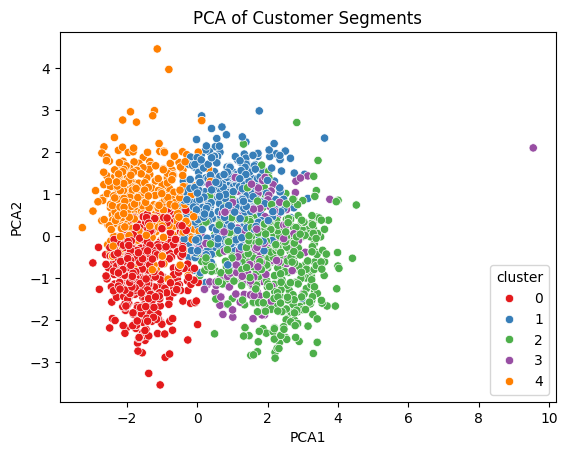

In [ ]:
#Visualisation des clusters dans le plan PCA
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_pca, palette='Set1')
plt.title('PCA of Customer Segments')
plt.show()

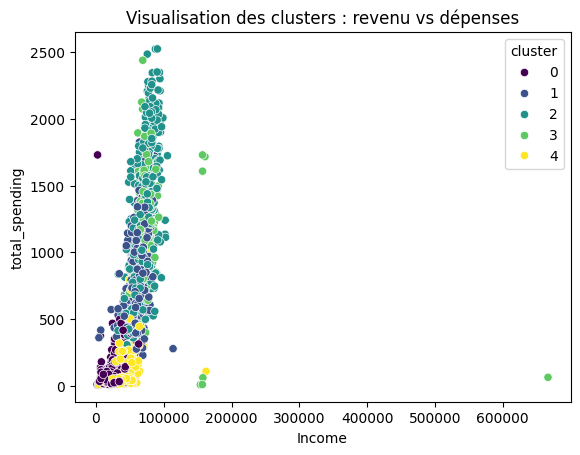

In [ ]:
# Visualisation des clusters selon revenu et dépenses
sns.scatterplot(x='Income', y='total_spending', hue='cluster', data=df_clustered, palette='viridis')
plt.title("Visualisation des clusters : revenu vs dépenses")
plt.show()

In [ ]:
# Description textuelle des clusters

def describe_cluster(cluster_id: int, profiles: pd.DataFrame, global_mean: pd.Series):
    row = profiles.loc[cluster_id]
    lines = []
    
    def updown(col, name=None):
        name = name or col
        if col not in row.index or col not in global_mean.index:
            return
        val = row[col]
        ref = global_mean[col]
        if val > ref:
            lines.append(f"- {name} au-dessus de la moyenne ({val:.2f} vs {ref:.2f})")
        else:
            lines.append(f"- {name} en dessous de la moyenne ({val:.2f} vs {ref:.2f})")
    
    # Features clés
    for col in ["Income", "total_spending", "Recency", "since_customer", "Age", "total_children", "NumWebPurchases", "NumStorePurchases", "AcceptedAny"]:
        updown(col)
        
    return "\n".join(lines)

for cid in sorted(df_clustered["cluster"].unique()):
    print(f"\n### Cluster {cid}")
    print(describe_cluster(cid, cluster_profiles_mean, global_mean))
#!/usr/bin/env python3



### Cluster 0
- Income en dessous de la moyenne (30368.65 vs 52237.98)
- total_spending en dessous de la moyenne (101.33 vs 605.80)
- Recency en dessous de la moyenne (48.38 vs 49.11)
- since_customer en dessous de la moyenne (4575.28 vs 4578.61)
- Age en dessous de la moyenne (49.14 vs 57.19)
- total_children en dessous de la moyenne (0.82 vs 0.95)
- NumWebPurchases en dessous de la moyenne (2.13 vs 4.08)
- NumStorePurchases en dessous de la moyenne (3.15 vs 5.79)
- AcceptedAny en dessous de la moyenne (0.14 vs 0.27)

### Cluster 1
- Income au-dessus de la moyenne (60580.48 vs 52237.98)
- total_spending au-dessus de la moyenne (791.42 vs 605.80)
- Recency au-dessus de la moyenne (49.31 vs 49.11)
- since_customer au-dessus de la moyenne (4609.35 vs 4578.61)
- Age au-dessus de la moyenne (61.21 vs 57.19)
- total_children au-dessus de la moyenne (1.06 vs 0.95)
- NumWebPurchases au-dessus de la moyenne (6.76 vs 4.08)
- NumStorePurchases au-dessus de la moyenne (8.42 vs 5.79)
- AcceptedAn

In [ ]:
# Attribution de noms aux clusters
cluster_names = {
    0: "Segment A",
    1: "Segment B",
    2: "Segment C",
    3: "Segment D",
    4: "Segment E",
}

df_clustered["segment_name"] = df_clustered["cluster"].map(cluster_names)
df_clustered[["cluster", "segment_name"]].head()
print(" Segments nommés")

 Segments nommés


In [ ]:
# Analyse et Recommandations métier par segment
segment_actions = {
    "Segment A": "Offres premium / fidélisation haut de gamme / upsell",
    "Segment B": "Promotions ciblées / bundles / cross-sell",
    "Segment C": "Campagne de réactivation / coupons retour",
    "Segment D": "Offres familiales / pack / réduction volume",
    "Segment E": "Stratégie digitale (emailing, retargeting, web-only offers)",
}

actions_df = pd.DataFrame({
    "segment_name": list(segment_actions.keys()),
    "reco_metier": list(segment_actions.values())
})

actions_df


,segment_name,reco_metier
0,Segment A,Offres premium / fidélisation haut de gamme / ...
1,Segment B,Promotions ciblées / bundles / cross-sell
2,Segment C,Campagne de réactivation / coupons retour
3,Segment D,Offres familiales / pack / réduction volume
4,Segment E,"Stratégie digitale (emailing, retargeting, web..."


In [ ]:
reports_dir = Path(config["paths"]["reports"])
reports_dir.mkdir(parents=True, exist_ok=True)

df_clustered.to_csv(reports_dir / "customers_with_clusters.csv", index=False)
cluster_distribution.to_csv(reports_dir / "cluster_distribution.csv")
cluster_profiles_mean.to_csv(reports_dir / "cluster_profiles_mean.csv")
cluster_profiles_median.to_csv(reports_dir / "cluster_profiles_median.csv")
diff_vs_global.to_csv(reports_dir / "cluster_diff_vs_global.csv")

print(" Livrables sauvegardés dans :", reports_dir.resolve())


✅ Livrables sauvegardés dans : C:\customer_segmentation\reports
